
# Load the data



In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 

#first put a shortcut in your drive to the image processing folder

#Choose the image folder you want to try

pipeFolder = '10.8Prepro+glcm+fixed+CorrectedLabels'

RESULTS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        pipeFolder)

MODELS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        'MLModelsFinal')

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(RESULTS_DIR))

results_file = os.listdir(RESULTS_DIR)

['20586908_6c613a14b80a8591_MG_R_CC_ANON__fos_glcm.csv', '20586934_6c613a14b80a8591_MG_L_CC_ANON__fos_glcm.csv', '20586960_6c613a14b80a8591_MG_R_ML_ANON__fos_glcm.csv', '20586986_6c613a14b80a8591_MG_L_ML_ANON__fos_glcm.csv', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON__fos_glcm.csv', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON__fos_glcm.csv', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON__fos_glcm.csv', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON__fos_glcm.csv', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON__fos_glcm.csv', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON__fos_glcm.csv', '20587294_e634830794f5c1bd_MG_R_CC_ANON__fos_glcm.csv', '20587320_e634830794f5c1bd_MG_L_CC_ANON__fos_glcm.csv', '20587346_e634830794f5c1bd_MG_R_ML_ANON__fos_glcm.csv', '20587372_e634830794f5c1bd_MG_L_ML_ANON__fos_glcm.csv', '20587466_d571b5880ad2a016_MG_L_CC_ANON__fos_glcm.csv', '20587492_d571b5880ad2a016_MG_R_ML_ANON__fos_glcm.csv', '20587518_d571b5880ad2a016_MG_L_ML_ANON__fos_glcm.csv', '20587544_d571b5880ad2a016_MG_R_CC_ANON__fos_gl

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import pickle



In [ ]:
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import copy

In [ ]:
import pandas as pd
import os
import cv2
#!pip install fastprogress
from fastprogress import master_bar, progress_bar
#!pip install tqdm
from tqdm.notebook import tqdm_notebook
from skimage import measure
from matplotlib import pyplot as plt

In [ ]:
def read_results_train_test(path, keys):
  df_result = pd.DataFrame()
  for result in os.listdir(path):
    if result.split('.')[-1] == 'csv':
      if int(result.split('_')[0]) in list(keys):
        try:
          df = pd.read_csv(path+'/'+result)
          df_result = df_result.append(df)
        except:
          print("Empty file ", result)
  return df_result

In [ ]:
def read_results(path):
  dfs = pd.DataFrame()
  for result in results_file:
    try:
      df = pd.read_csv(path+'/'+result)
    except:
      print("Empty file ", result)

    dfs = dfs.append(df)
  
  return dfs


In [ ]:
def train_test_function():
  df_train_test = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'standard_partitions.csv'), index_col=0)
  train_keys = df_train_test.loc[df_train_test.partition == 'train']['image_id'].values
  test_keys = df_train_test.loc[df_train_test.partition == 'test']['image_id'].values


  dfs_train = read_results_train_test(RESULTS_DIR, train_keys)
  dfs_test = read_results_train_test(RESULTS_DIR, test_keys)
  return dfs_train,dfs_test

In [ ]:
# dfs_train, dfs_test = train_test_function()
# dfs_train.label.value_counts()

# **Preprocessing**

In [ ]:
# We will balance data randomly taking  the same amount of 0 and 1 label inputs. There are several options to manage unbalanced data,
# this is just one approach, we should try different approaches.
# https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f
def rus(dfs, not_consider=0):
  # df_negative = dfs.loc[dfs.label == dfs.label.value_counts().idxmax()] #This is for making it more general
  df_negative = dfs.loc[dfs.label == 0] #Take all negative samples from dfs -> label = 0
  print('rus negative 1: ', len(df_negative))
  print('rus negative 1 without duplicates: ', len(df_negative.drop_duplicates()))
  #Here we are taking a subset from the 'negative pool' called df_negative with length equal to the number of positive candidates I have
  if not_consider >= len(dfs.loc[dfs.label == 1]):
    df_0 = pd.DataFrame()
  else:
    df_0 = df_negative.sample(len(dfs.loc[dfs.label == 1])-not_consider, random_state = 1) #not consider is the number of negative samples that I already have and that I misclassified the first time
  print('df_0: ', len(df_0))
  print('append ', len(df_negative.append(df_0)))
  print('df_negative drop no keeping', len(df_negative.drop_duplicates(keep=False)))
  df_negative = df_negative.append(df_0).drop_duplicates(keep=False) #df_negative is the samples that have not been used, and have not been selected yet for the training
  print('after drop duplicates with appended: ',len(df_negative))
  dfs_eq = df_0.append(dfs.loc[dfs.label == 1]) #dfs.label.value_counts().idxmin() #Here we are taking the balanced tada
  print("Length of balanced data: ", len(dfs_eq))
  print(dfs_eq['label'].value_counts())
  return dfs_eq, df_negative

In [ ]:
def plotFeatures(data):
  #plot the scatter matrix
  pd.plotting.scatter_matrix(data,figsize=(25,25))
  #correlation plot
  corr = data.corr()
  f, ax = plt.subplots(figsize=(25, 25))
  sns.heatmap(corr,annot=True)

In [ ]:
def standardScaler(X_train, X_test):
  standard_scaler = preprocessing.StandardScaler()
  X_train = standard_scaler.fit_transform(X_train)
  X_test = standard_scaler.transform(X_test)
  return X_train, X_test

# **Feature Engineering**

In [ ]:
def featureSelectionTrees(estimators, X_train, y_train, X_test):
  clf = ExtraTreesClassifier(n_estimators=estimators)
  clf = clf.fit(X_train, y_train)
  model = SelectFromModel(clf, prefit=True)
  X_train = model.transform(X_train)
  X_test = model.transform(X_test)
  return X_train, X_test

In [ ]:
def pcaAnalysis(components, X_train, X_test):
  pca = PCA(components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("PCA variance ratio: ", pca.explained_variance_ratio_)
  print("Total variance Explained by PCA: ", sum(pca.explained_variance_ratio_))
  return X_train, X_test

In [ ]:
def selectFeaturesChi(k, X_train, X_test, y_train):
  sel = SelectKBest(chi2, k=k)
  sel.fit(X_train, y_train)
  X_train = sel.transform(X_train)
  X_test = sel.transform(X_test)
  return X_train, X_test

# **Classification**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.metrics import matthews_corrcoef

In [ ]:

def RandomForest(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    print("Searching for best hyperparameters")
    params = {'criterion': ['gini'],
              'n_estimators': [100], # , 500, 900
              'max_features': ['auto', 'sqrt'],#, 'sqrt', 'log2'
              'max_depth' : [10, 12]}
    grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs = -1), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for rf are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = RandomForestClassifier(random_state=42, n_jobs = -1)
  
  return classifier, best_params

In [ ]:

from sklearn.ensemble import GradientBoostingClassifier # gradient boosting regressor
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
def GradientBoosting(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'learning_rate': [0.1],#0.05, 0.2
              #'min_samples_split': [0.5, 0.8],
              #'min_samples_leaf': [0.1, 0.2, 0.5],
              'max_depth':[8],
              #'max_features':['sqrt'],#'log2'
              #'criterion': ['friedman_mse',  'mae'],
              #'subsample':[0.5, 1.0],
              'n_estimators':[600]}
    grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for gb are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))

  classifier = GradientBoostingClassifier(random_state=42)
  
  return classifier, best_params

In [ ]:
from sklearn.ensemble import AdaBoostClassifier # adaboost, adaboostRegressor for regression problems

def AdaBoost(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'n_estimators': [600],
              'learning_rate': [0.5]}
    grid = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for ab are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = AdaBoostClassifier(random_state=42)

  return classifier, best_params

In [ ]:
from sklearn.linear_model import LogisticRegression

def LogRegre(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'multi_class':['multinomial'],
              'solver': ['sag'],#,'saga'
              'penalty': ['l2']}#'elasticnet',
    grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for lrg are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = LogisticRegression(random_state=42)
  
  return classifier, best_params

In [ ]:
def KNN(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'n_neighbors':[3,5]}
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

  classifier = KNeighborsClassifier()

  return classifier, best_params

In [ ]:


def DecisionTree(X_train, y_train, cv=5, best_params = dict()):
  classifier = tree.DecisionTreeClassifier()
 

  return classifier, best_params

In [ ]:
# This is an example of how to use a Pipe inside a function we are training, as done in Challenge 3 by the professor
def SVC_linear(X_train, y_train, cv=5, best_params = dict()):

  if len(best_params) == 0:
    lower_value_C = 1
    higher_value_C = 10
    n_values = 10
    base = 10
    params = {'C': [1, 3, 5,9.11], #12
              'kernel' : ['rbf'],
              'gamma': [2.5, 5, 10]}

    grid = GridSearchCV(SVC(random_state = 42, probability=True), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for svm are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = SVC(random_state = 42, probability=True)

  return classifier, best_params

In [ ]:
def cv_classification(classifier, params, X_train, X_test, y_train, y_test, candidates_train, candidates_test, normals, clf_name, imageKeyLocation):
  
  trainDataFull = pd.DataFrame(X_train).copy()
  ss_f1 = StandardScaler()
  trainDataFull = pd.DataFrame(ss_f1.fit_transform(trainDataFull), columns=X_train.columns)
  trainDataFull['label'] = y_train

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_train_f1 = dataBalanced.drop('label', axis=1)
  y_train_f1 = dataBalanced['label']

  clf1 = clone(classifier)
  clf1.set_params(**params)
  cvf1Score = []
  cvMccScore = []
  cvpAUCScore = []

  print("******************** RESULTS FOLD 1 *****************************")
  selectedFold = 1
  clf1.fit(X_train_f1, y_train_f1)
  print('TRAIN')
  y_pred_tr_1 = clf1.predict(X_train_f1)
  print(confusion_matrix(y_train_f1, y_pred_tr_1))
  print(f1_score(y_train_f1, y_pred_tr_1))

  y_pred_proba_tr = clf1.predict_proba(X_train_f1)[:, 1]
  print('pAUC train: ', roc_auc_score(y_train_f1, y_pred_proba_tr, max_fpr = 0.0001))

  
  print('TEST')
  y_pred_1 = clf1.predict(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))
  print(confusion_matrix(y_test, y_pred_1))
  print(f1_score(y_test, y_pred_1))
  y_pred_proba = clf1.predict_proba(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))[:, 1]
  print('pAUC test: ', roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))

  print(classification_report(y_test, y_pred_1))  
  print('F1 score test: ', f1_score(y_test, y_pred_1, average='binary'))

  df_cm = confusion_matrix(y_test, y_pred_1)
  plt.figure(figsize=(5,5))
  sns.heatmap(df_cm, annot=True, fmt='d') # font size
  plt.show()

  filename = f'best_model_{clf_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'
  pickle.dump(clf1, open(os.path.join(MODELS_DIR,'rus_scaled', filename), 'wb'))
  print(f"Fold {selectedFold} of {clf_name} was saved!")  


  cvf1Score.append(f1_score(y_test, y_pred_1, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_test, y_pred_1))
  cvpAUCScore.append(roc_auc_score(y_test, clf1.predict_proba(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))[:, 1], max_fpr = 0.0001))


  candidates_unique = [cand.split('_')[imageKeyLocation] for cand in candidates_test['name'].values.tolist()]
  candidates_unique = list(set(candidates_unique))
  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]
  print(len(groundTruthShort))
  normals_f1 = [i for i in normals if i in candidates_unique]


  fn_1, dfROC_1, filename_key_1 = calculateFROC(groundTruthShort, normals_f1, candidates_test, y_pred_proba, classifier, pipeFolder)

  print("*********************** RESULTS FOLD 2 *******************************")
  selectedFold = 2
  trainDataFull = pd.DataFrame(X_test).copy()
  ss_f2 = StandardScaler()
  trainDataFull = pd.DataFrame(ss_f2.fit_transform(trainDataFull), columns=X_test.columns)
  trainDataFull['label'] = y_test

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_test_f2 = dataBalanced.drop('label', axis=1)
  y_test_f2 = dataBalanced['label']

  clf2 = clone(classifier)
  clf2.set_params(**params)
  clf2.fit(X_test_f2, y_test_f2)

  print('TRAIN')
  y_pred_tr_2 = clf2.predict(X_test_f2)
  print(confusion_matrix(y_test_f2, y_pred_tr_2))
  print(f1_score(y_test_f2, y_pred_tr_2))
  y_pred_proba_tr = clf2.predict_proba(X_test_f2)[:, 1]
  print('pAUC train: ', roc_auc_score(y_test_f2, y_pred_proba_tr, max_fpr = 0.0001))

  print('TEST')
  y_pred_2 = clf2.predict(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))
  print(confusion_matrix(y_train, y_pred_2))
  print(f1_score(y_train, y_pred_2))
  y_pred_proba_2 = clf2.predict_proba(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))[:, 1]
  print('pAUC test: ', roc_auc_score(y_train, y_pred_proba_2, max_fpr = 0.0001))

  print(classification_report(y_train, y_pred_2))  

  print('F1 score: ', f1_score(y_train, y_pred_2, average='binary'))
  df_cm = confusion_matrix(y_train, y_pred_2)
  plt.figure(figsize=(5,5))
  sns.heatmap(df_cm, annot=True, fmt='d') # font size
  plt.show()

  filename = f'best_model_{clf_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'
  pickle.dump(clf2, open(os.path.join(MODELS_DIR,'rus_scaled', filename), 'wb'))
  print(f"Fold {selectedFold} of {clf_name} was saved!")  

  cvf1Score.append(f1_score(y_train, y_pred_2, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_train, y_pred_2))
  cvpAUCScore.append(roc_auc_score(y_train, clf2.predict_proba(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))[:, 1], max_fpr = 0.0001))
  print("Mean CV_score F1-score: ", np.mean(cvf1Score))

  candidates_unique = [cand.split('_')[imageKeyLocation] for cand in candidates_train['name'].values.tolist()]
  candidates_unique = list(set(candidates_unique))
  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]
  print(len(groundTruthShort))
  normals_f2 = [i for i in normals if i in candidates_unique]

  fn_2, dfROC_2, filename_key_2 = calculateFROC(groundTruthShort, normals_f2, candidates_train, y_pred_proba_2, clf_name, pipeFolder)
  
  
  # Choose the best one
  if np.array(cvf1Score).argmax() == 0:  
    best_f1 = f1_score(y_test, y_pred_1)
    best_mcc = matthews_corrcoef(y_test, y_pred_1)
    best_pAUC = roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001)
    
  else:
    best_f1 = f1_score(y_train, y_pred_2)
    best_mcc = matthews_corrcoef(y_train, y_pred_2)
    best_pAUC = roc_auc_score(y_train, y_pred_proba_2, max_fpr = 0.0001)    


  print("cvf1Score: ", cvf1Score)
  dfROC_1 = dfROC_1.append(dfROC_2)

  return np.array(cvf1Score).argmax(),[np.mean(cvpAUCScore), np.mean(cvf1Score), np.mean(cvMccScore)], [best_pAUC, best_f1, best_mcc], dfROC_1, fn_1+fn_2

# **Scores**

In [ ]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [ ]:
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

In [ ]:
import cv2

def calculateFROC(groundTruthsList, normals, candidates, prediction, model, pipeline):

  #List needed for counting
  evaluationList = []

  # evaluation froc curve #

  fn = 0 # false negative, for the blobs that do not belong to any component
  positive_candidates = 0
  flag = True

  rowListdfROC = []

  candidates_copy= candidates.copy()
  candidates_copy['prediction'] = prediction

  for imageKey in tqdm_notebook(groundTruthsList):


    evaluationList = []
 
    # list of features found with y,x and sigma
    candidatesImg = candidates_copy.loc[candidates_copy['name'].str.contains(imageKey.split('_')[0], regex=False)]
    candidates_number = len(candidatesImg)
#    print('cand number: ', candidates_number)

    mask = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', imageKey), cv2.IMREAD_GRAYSCALE)

 #   print('# IMAGEKEY: ', imageKey)
    blobs = mask > 0.7 * mask.mean() #Thresholding the backgroudnd
    blobs_labels, count = measure.label(blobs, background=0, return_num=True) #Getting labels of the connected components and the amount of them without considering the count

    # dictionaries
    dictCounting={}

    for index in range(1, count+1):
      dictCounting[index] = 0
    
    evaluationList = []
    dictMean = {}


    for index2, candidate in candidatesImg.iterrows():
      sigma = 7

      if (imageKey.split('_')[0] in normals):
        if candidate['name'].split('_')[1] not in dictMean.keys():
          dictMean[candidate['name'].split('_')[1]] = [candidate.prediction]
        else:
          dictMean[candidate['name'].split('_')[1]].append(candidate.prediction)
        continue

      # is the image a normal image?

      if (((candidate.x - sigma) < 0) or 
        ((candidate.x + sigma) > mask.shape[0]) or 
        ((candidate.y - sigma) < 0) or
        ((candidate.y + sigma) > mask.shape[1])):
        continue


      # n = 3
      left = int(candidate.x - sigma)
      right = int(candidate.x + sigma)
      top = int(candidate.y - sigma)
      bottom = int(candidate.y + sigma) 

      #    y : y + w , x : x +  h
      nonzero = cv2.countNonZero(blobs_labels[top:bottom, left: right])

      if nonzero > 0:
        # Find all connected components (cc) that intersect with the candidate
        foundCC = [i for i in np.unique(blobs_labels[top:bottom, left: right]) if i!= 0]

        # Keep the maximum prediction of the candidates that intsersect with at least one component
        for cc in foundCC:
          dictCounting[cc] = max(candidate.prediction, dictCounting[cc])

    if (imageKey.split('_')[0] not in normals):
      for key,value in dictCounting.items():
        if np.sum(blobs_labels == key) > np.floor(np.pi*(15/2.0)**2):
#          print("Too big... discarded")
          continue
        if value > 0:
            rowListdfROC.append(['TP', value])
        else:
          fn = fn + 1
    else:
      if len(dictMean.keys()) > 0:
        for key, value in dictMean.items():
          rowListdfROC.append(['FP', np.max(np.array(value))])


  filename_key = 'FROC_calculations_{}_pip{}_fn{}_normals{}_rus_scaled.csv'.format(model, pipeline, fn, len(normals))

  dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

  dfROC.to_csv(os.path.join(MODELS_DIR,
                            'rus_scaled',
                            filename_key))
  
  print("File saved as ", filename_key)



  return fn, dfROC, filename_key

In [ ]:
def writeFile(df, flag, name):
  if(flag):
    df.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 name),
                    mode='a',
                    index=False)
    flag = False
  else:
    df.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 name),
                  mode='a',
                  header=False,
                  index=False)
  return flag

In [ ]:
import matplotlib.pyplot as plt
from numpy import trapz

def draw_curve(fn, normals, dfROC, name, clf_name):

  experiments_results_path = os.path.join(MODELS_DIR, 'rus_scaled')
  results_filename = f'results_AUC_rus_scaled_{pipeFolder}.csv'
  confusion_matrix_filename = f'results_ConfMat_rus_scaled_{pipeFolder}.csv'


  if results_filename not in os.listdir(experiments_results_path):
    results_df = pd.DataFrame(columns=["model", "AUC_TOTAL", "AUC_final_50fPpi", "F1_final"])
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
  
    results_confmat = pd.DataFrame(columns=["model", "TP", "FP", "FN", "Total True"])
    results_confmat.to_csv(os.path.join(experiments_results_path, confusion_matrix_filename), index=False)
  
  
  else:
    results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))
    results_confmat = pd.read_csv(os.path.join(experiments_results_path, confusion_matrix_filename))

  tpc = 0
  fpc = 0
  tpr = []
  fppi = []

  dfROC['prob'] = [round(i,4) for i in dfROC['prob'].values]
  dfROC = dfROC.sort_values('prob', ascending=False)

  thresholds = dfROC.prob.unique()
  print('Number of thresholds: ', len(thresholds))
  print(thresholds)

  tp = len(dfROC.loc[dfROC.type == 'TP'])
  print('true positives: ', tp)
  fp = len(dfROC.loc[dfROC.type == 'FP'])
  print('false positives: ',  fp)
  print("Total number of positives: ", tp+fn)

  for i in progress_bar(range(len(thresholds))):

    tpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type=='TP')])
    fpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type!='TP')])
              
    # print('TP amount {} in threshold {}'.format(tpc, thresholds[i]))
    # print('FP amount {} in threshold {}'.format(fpc, thresholds[i]))
    

    tpr.append( tpc/(tp+fn) )
    fppi.append( fpc/normals )
    tpc = 0
    fpc = 0
  
  gamma = [i for i in fppi if i <= 50 ]
  print(max(fppi))
  auc_total = trapz(tpr, x=fppi)/max(fppi)
  print(max(gamma))
  auc_final = trapz(tpr[0:len(gamma)], x=gamma)/max(gamma)

  print('AUC TOTAL:', auc_total)
  fig, ax = plt.subplots()
  ax.plot(fppi, tpr)
  ax.set_xlabel('fPpI', fontsize=15)
  ax.set_ylabel('TPR', fontsize=15)
  ax.grid(True)
  plt.ylim(0,1)
  plt.show()


  print('AUC final:', auc_final)
  fig1, ax1 = plt.subplots()
  ax1.plot(gamma, tpr[0:len(gamma)])
  ax1.set_xlabel('fPpI', fontsize=12)
  ax1.set_ylabel('TPR', fontsize=12)
  ax1.grid(True)
  plt.ylim(0,1)
  plt.xlim(0,50)

  plt.savefig(os.path.join(MODELS_DIR,
                          'rus_scaled', 
                           name+'.eps'), format='eps')
  plt.show()
    
  final_f1 = tp / (tp + (fp + fn)/2)

  row_results = [clf_name, auc_total, auc_final, final_f1]
  results_df = results_df.append(pd.DataFrame([row_results], columns=["model", "AUC_TOTAL", "AUC_final_50fPpi", "F1_final"]))
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

  confmat_results = [clf_name, tp, fp, fn, tp+fn]
  results_confmat = results_confmat.append(pd.DataFrame([confmat_results], columns=["model", "TP", "FP", "FN", "Total True"]))
  results_confmat.to_csv(os.path.join(experiments_results_path, confusion_matrix_filename), index=False)




In [ ]:
def load_and_predict(selectedFold, classifier_name):

  #Reading data
  dfs_train, dfs_test = train_test_function()
  print('Length of train set: ', len(dfs_train))
  print('Length of test set: ', len(dfs_test))

  dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
  dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

  dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
  dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
  print('Length of train set: ', len(dfs_train))
  print('Length of test set: ', len(dfs_test))

  try:  
    if dfs_train.isnull().values.any():
      colm = dfs_train.columns[dfs_train.isna().any()]
      dfs_train = dfs_train[dfs_train[colm[0]].notna()]

    if dfs_test.isnull().values.any():
      colm = dfs_test.columns[dfs_test.isna().any()]    
      dfs_test = dfs_test[dfs_test[colm[0]].notna()]

    print("Train dfs without nans: ", len(dfs_train))
    print("Test dfs without nans: ",len(dfs_test))

  except Exception as e:
    print("No nan values to drop, or not columns")
    print(e)

  y_train = dfs_train['label'].reset_index(drop=True)
  candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
  X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

  y_test = dfs_test['label'].reset_index(drop=True)
  candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
  X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)


  #Obtain train-test datasets
  if selectedFold == 2:
    chosenCandidates = candidates_train
    trainDataFull = pd.DataFrame(X_test).copy()
    ss_f2 = StandardScaler()
    trainDataFull = pd.DataFrame(ss_f2.fit_transform(trainDataFull), columns=X_test.columns)
    trainDataFull['label'] = y_test

    model = pickle.load(open(os.path.join(MODELS_DIR,'rus_scaled', f'best_model_{classifier_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'), 'rb'))
    y_pred = model.predict(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))
    y_pred_proba = model.predict_proba(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))[:,1]

  else:
    chosenCandidates = candidates_test
    trainDataFull = pd.DataFrame(X_train).copy()
    ss_f1 = StandardScaler()
    trainDataFull = pd.DataFrame(ss_f1.fit_transform(trainDataFull), columns=X_train.columns)
    trainDataFull['label'] = y_train

    model = pickle.load(open(os.path.join(MODELS_DIR,'rus_scaled', f'best_model_{classifier_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'), 'rb'))
    y_pred = model.predict(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))
    y_pred_proba = model.predict_proba(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))[:,1]


  normals = []
  with open(os.path.join(RESULTS_DIR,'normals_final.txt')) as f:
      for line in f:
          normals.append(line[:-1])

  if 'glcm' in pipeFolder:
    imageKeyName = 2
  else:
    imageKeyName = 3

  candidates_unique = [cand.split('_')[imageKeyName] for cand in chosenCandidates['name'].values.tolist()]

  candidates_unique = list(set(candidates_unique))

  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]

  print(len(groundTruthShort))

  normals = [i for i in normals if i in candidates_unique]

  print("Calculating fROC file...") 
  fn, dfROC, filename_key = calculateFROC(groundTruthShort, normals, chosenCandidates, y_pred_proba, classifier_name, pipeFolder+'_loaded_')
  print(len(dfROC.prob.unique()))
  draw_curve(fn, len(normals), dfROC, filename_key[:-4], classifier_name)


# **Main**

In [ ]:
# https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573#a642
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

<IPython.core.display.Javascript object>

**Cross validation classification**

Length of train set:  378938
Length of test set:  394560
Length of train set:  341044
Length of test set:  355104
Train dfs without nans:  341044
Test dfs without nans:  355104
rus negative 1:  334676
rus negative 1 without duplicates:  334655
df_0:  6368
append  341044
df_negative drop no keeping 334647
after drop duplicates with appended:  328279
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328279
rus negative 1:  334676
rus negative 1 without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[6368    0]
 [   0 6368]]
1.0
pAUC train:  1.0
TEST
[[319508  32248]
 [   402   2946]]
0.15287219137564217
pAUC test:  0.5029212032971089
              prec

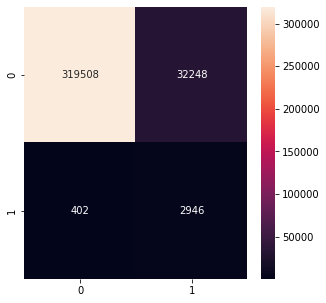

Fold 1 of gb was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_GradientBoostingClassifier(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn423_normals49_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative 1:  351756
rus negative 1 without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3348    0]
 [   0 3348]]
1.0
pAUC train:  1.0
TEST
[[305570  29106]
 [   867   5501]]
0.26850518608907875
pAUC test:  0.5015212397603397
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    334676
           1       0.16      0.86      0.27      6368

    accuracy                           0.91    341044
   macro avg       0.58      0.89      0.61    341044
weighted avg       0.98      0.91      0.94    341044

F1 score:  0.

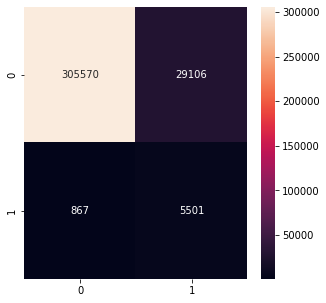

Fold 2 of gb was saved!
Mean CV_score F1-score:  0.21068868873236046
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_GradientBoostingClassifier(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn750_normals55_rus_scaled.csv
cvf1Score:  [0.15287219137564217, 0.26850518608907875]
Number of thresholds:  8649
[1.000e+00 9.999e-01 9.998e-01 ... 2.000e-04 1.000e-04 0.000e+00]
true positives:  4325
false positives:  154443
Total number of positives:  5498


1424.8095238095239
49.94285714285714
AUC TOTAL: 0.744122795460324


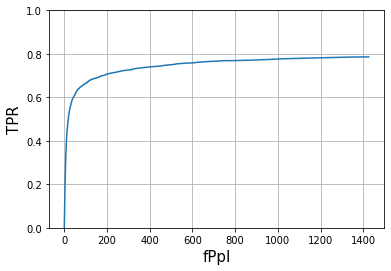

AUC final: 0.4861760805329946


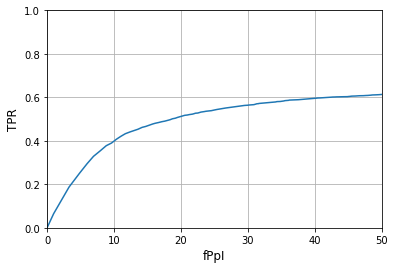

rus negative 1:  334676
rus negative 1 without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[6162  206]
 [ 340 6028]]
0.9566735438819235
pAUC train:  0.8834740732011475
TEST
[[321353  30403]
 [   408   2940]]
0.1602572838025674
pAUC test:  0.506624660477121
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    351756
           1       0.09      0.88      0.16      3348

    accuracy                           0.91    355104
   macro avg       0.54      0.90      0.56    355104
weighted avg       0.99      0.91      0.95    355104

F1 score test:  0.1602572838025674


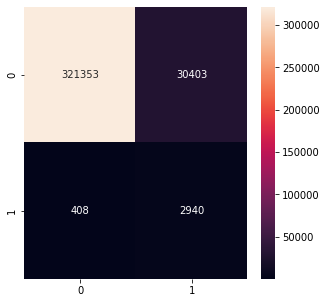

Fold 1 of rf was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_RandomForestClassifier(n_jobs=-1, random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn423_normals49_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative 1:  351756
rus negative 1 without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3262   86]
 [ 167 3181]]
0.961753590325019
pAUC train:  0.8991885078124874
TEST
[[309201  25475]
 [   901   5467]]
0.29305816135084434
pAUC test:  0.5025401621946197
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    334676
           1       0.18      0.86      0.29      6368

    accuracy                           0.92    341044
   macro avg       0.59      0.89      0.63    341044
weighted avg       0.98      0.9

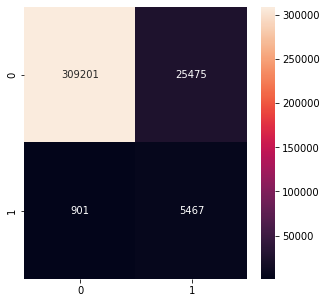

Fold 2 of rf was saved!
Mean CV_score F1-score:  0.22665772257670586
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_RandomForestClassifier(n_jobs=-1, random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn750_normals55_rus_scaled.csv
cvf1Score:  [0.1602572838025674, 0.29305816135084434]
Number of thresholds:  9680
[9.991e-01 9.989e-01 9.986e-01 ... 2.000e-04 1.000e-04 0.000e+00]
true positives:  4325
false positives:  154443
Total number of positives:  5498


1378.1142857142856
49.99047619047619
AUC TOTAL: 0.7449295129184075


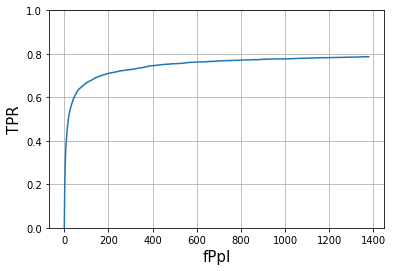

AUC final: 0.4930488587235276


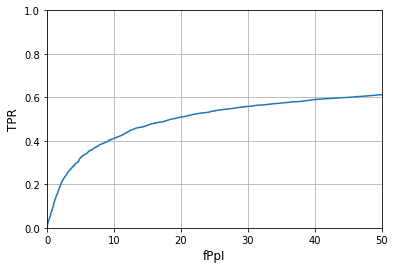

rus negative 1:  334676
rus negative 1 without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[5876  492]
 [ 674 5694]]
0.9071212362593595
pAUC train:  0.6212122163897139
TEST
[[319192  32564]
 [   422   2926]]
0.1506771718420104
pAUC test:  0.5012711840520885
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    351756
           1       0.08      0.87      0.15      3348

    accuracy                           0.91    355104
   macro avg       0.54      0.89      0.55    355104
weighted avg       0.99      0.91      0.94    355104

F1 score test:  0.1506771718420104


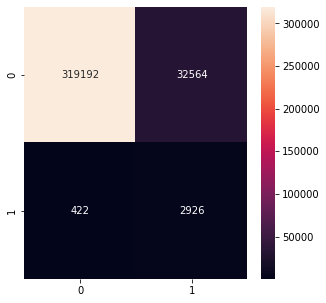

Fold 1 of adaboost was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_AdaBoostClassifier(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn423_normals49_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative 1:  351756
rus negative 1 without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3091  257]
 [ 381 2967]]
0.9029214850882532
pAUC train:  0.7449095871758941
TEST
[[306263  28413]
 [   870   5498]]
0.2729958539189155
pAUC test:  0.5011228098728817
              precision    recall  f1-score   support

           0       1.00      0.92      0.95    334676
           1       0.16      0.86      0.27      6368

    accuracy                           0.91    341044
   macro avg       0.58      0.89      0.61    341044
weighted avg       0.98      0.91      0.94    

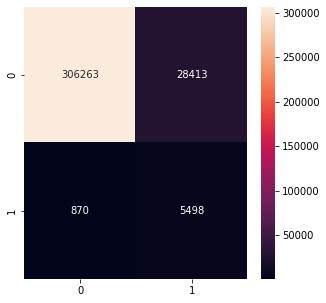

Fold 2 of adaboost was saved!
Mean CV_score F1-score:  0.21183651288046296
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_AdaBoostClassifier(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn750_normals55_rus_scaled.csv
cvf1Score:  [0.1506771718420104, 0.2729958539189155]
Number of thresholds:  536
[0.5212 0.5208 0.5207 0.5206 0.5198 0.5197 0.5192 0.519  0.5189 0.5185
 0.5183 0.5182 0.5181 0.518  0.5179 0.5177 0.5173 0.5172 0.5171 0.517
 0.5169 0.5168 0.5167 0.5165 0.5164 0.5163 0.5161 0.5159 0.5158 0.5156
 0.5154 0.5153 0.5152 0.5148 0.5147 0.5146 0.5145 0.5144 0.5143 0.5142
 0.5141 0.514  0.5139 0.5135 0.5134 0.5132 0.5131 0.5127 0.5126 0.5125
 0.5123 0.5122 0.5121 0.5119 0.5117 0.5115 0.5114 0.5112 0.5111 0.511
 0.5109 0.5108 0.5107 0.5106 0.5105 0.5104 0.5103 0.5102 0.5101 0.51
 0.5099 0.5098 0.5097 0.5096 0.5095 0.5094 0.5093 0.5092 0.5091 0.509
 0.5089 0.5088 0.5087 0.5086 0.5085 0.5084 0.5083 0.5082 0.5081 0.508
 0.5079 0.5078 0.5077 0.5076 0.5075 0.5074 0.5073 0.5072 0.5071 0.507
 0.5069 0.5068 0.5067 0.5066 0.5065 0.5064 0.5063 0.5062 0.5061 0.506
 0.505

1470.8761904761905
47.43809523809524
AUC TOTAL: 0.744324494782091


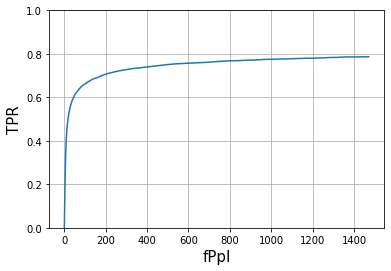

AUC final: 0.48155891624258024


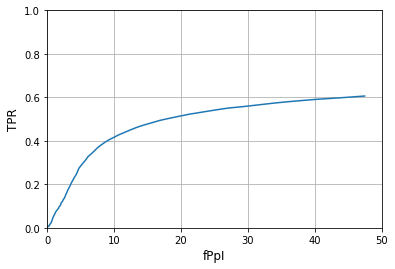

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


The best parameters for lrg are {'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'} with an accuracy of 0.9872
rus negative 1:  334676
rus negative 1 without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


TRAIN
[[5814  554]
 [ 797 5571]]
0.8918594412871208
pAUC train:  0.501074299946153
TEST
[[318867  32889]
 [   446   2902]]
0.1482919849766218
pAUC test:  0.5000436779384587
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    351756
           1       0.08      0.87      0.15      3348

    accuracy                           0.91    355104
   macro avg       0.54      0.89      0.55    355104
weighted avg       0.99      0.91      0.94    355104

F1 score test:  0.1482919849766218


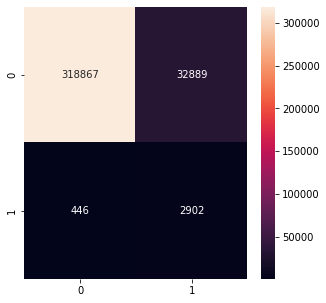

Fold 1 of logreg was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_LogisticRegression(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn423_normals49_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative 1:  351756
rus negative 1 without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


TRAIN
[[3049  299]
 [ 463 2885]]
0.8833435394978566
pAUC train:  0.5004230498263265
TEST
[[308245  26431]
 [   878   5490]]
0.2867664342239285
pAUC test:  0.5006695813177585
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    334676
           1       0.17      0.86      0.29      6368

    accuracy                           0.92    341044
   macro avg       0.58      0.89      0.62    341044
weighted avg       0.98      0.92      0.95    341044

F1 score:  0.2867664342239285


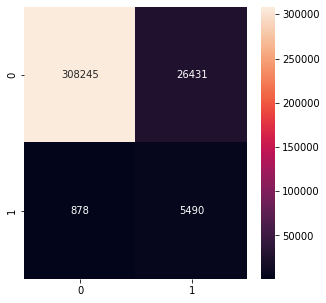

Fold 2 of logreg was saved!
Mean CV_score F1-score:  0.21752920960027516
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_LogisticRegression(random_state=42)_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn750_normals55_rus_scaled.csv
cvf1Score:  [0.1482919849766218, 0.2867664342239285]
Number of thresholds:  9712
[1.000e+00 9.999e-01 9.998e-01 ... 2.000e-04 1.000e-04 0.000e+00]
true positives:  4325
false positives:  154443
Total number of positives:  5498


1461.5523809523809
49.98095238095238
AUC TOTAL: 0.7457622362276444


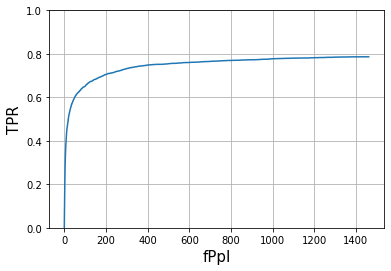

AUC final: 0.4877331883157068


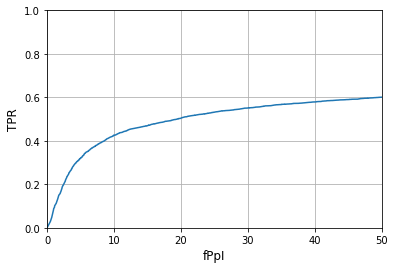

rus negative 1:  334676
rus negative 1 without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[5960  408]
 [ 608 5760]]
0.9189534141671984
pAUC train:  0.8580614875331287
TEST
[[318998  32758]
 [   451   2897]]
0.14855267543522294
pAUC test:  0.5006238620391338
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    351756
           1       0.08      0.87      0.15      3348

    accuracy                           0.91    355104
   macro avg       0.54      0.89      0.55    355104
weighted avg       0.99      0.91      0.94    355104

F1 score test:  0.14855267543522294


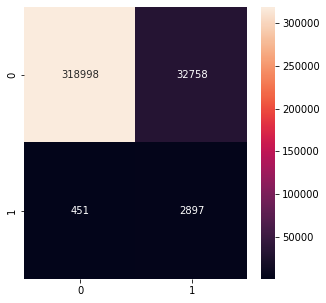

Fold 1 of knn was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_KNeighborsClassifier()_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn506_normals49_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative 1:  351756
rus negative 1 without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3116  232]
 [ 347 3001]]
0.9120194499316213
pAUC train:  0.8538960042386827
TEST
[[303633  31043]
 [   949   5419]]
0.25304692972215737
pAUC test:  0.5006554110436606
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    334676
           1       0.15      0.85      0.25      6368

    accuracy                           0.91    341044
   macro avg       0.57      0.88      0.60    341044
weighted avg       0.98      0.91      0.94    341044

F1 s

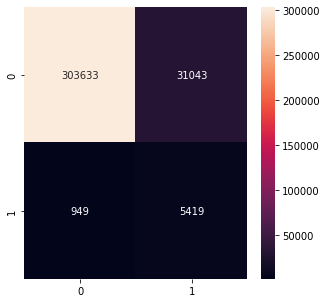

Fold 2 of knn was saved!
Mean CV_score F1-score:  0.20079980257869015
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_KNeighborsClassifier()_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn875_normals55_rus_scaled.csv
cvf1Score:  [0.14855267543522294, 0.25304692972215737]
Number of thresholds:  6
[1.  0.8 0.6 0.4 0.2 0. ]
true positives:  4117
false positives:  154443
Total number of positives:  5498


562.8571428571429
33.885714285714286
AUC TOTAL: 0.6751239644750068


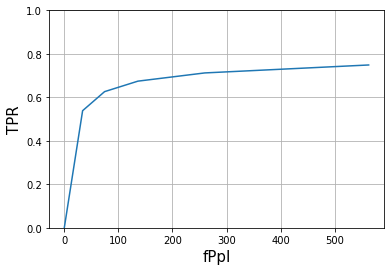

AUC final: 0.26927973808657696


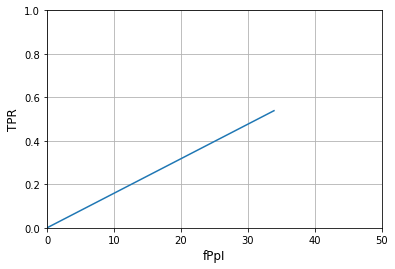

In [ ]:
# def main():
from sklearn.utils import shuffle

normals = []
with open(os.path.join(RESULTS_DIR,'normals_final.txt')) as f:
    for line in f:
        normals.append(line[:-1])

if 'glcm' in pipeFolder:
  imageKeyName = 2
else:
  imageKeyName = 3



classifiers = ['gb', 'rf', 'adaboost', 'logreg', 'knn', 'svm']
best_hyperparameters = dict()
y_pred_proba = []
f1_scores = []

experiments_results_path = os.path.join(MODELS_DIR, 'rus_scaled')
results_filename = f'results_rus_scaled_{pipeFolder}.csv'

if results_filename not in os.listdir(experiments_results_path):
  results_df = pd.DataFrame(columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"])
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
else:
  results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))

if len(results_df)>0:
  loadedFold = results_df.iloc[len(results_df)-1]['selectedFold']
else:
  loadedFold = -1

#Reading data
dfs_train, dfs_test = train_test_function()
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))

dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))


dfs_hyperOpt = shuffle(dfs_tr_hyperopt.append(dfs_ts_hyperopt))


#Preprocessing steps
#Manage unbalanced data
# dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

try:
  if dfs_train.isnull().values.any():
    colm = dfs_train.columns[dfs_train.isna().any()]
    dfs_train = dfs_train[dfs_train[colm[0]].notna()]

  if dfs_test.isnull().values.any():
    colm = dfs_test.columns[dfs_test.isna().any()]    
    dfs_test = dfs_test[dfs_test[colm[0]].notna()]

  if dfs_hyperOpt.isnull().values.any():
    colm = dfs_hyperOpt.columns[dfs_hyperOpt.isna().any()]
    dfs_hyperOpt = dfs_hyperOpt[dfs_hyperOpt[colm[0]].notna()]


  print("Train dfs without nans: ", len(dfs_train))
  print("Test dfs without nans: ",len(dfs_test))

except Exception as e:
  print("No nan values to drop, or not columns")
  print(e)

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)


#Plot features 
#  plotFeatures(data)

#Obtain train-test datasets


trainDataFull = pd.DataFrame(X_train).copy()
trainDataFull['label'] = y_train

dataBalanced, dfNegative = rus(trainDataFull)
print("Data Balanced: ", len(dataBalanced))
print("Negative pool: ",len(dfNegative))

trainBalanceData = dataBalanced.drop('label', axis=1)
trainBalanceLabel = dataBalanced['label']

hyperOptTrainData = dfs_hyperOpt.drop(['name', 'label',  'x', 'y'], axis=1)
ss = StandardScaler()
hyperOptTrainData = pd.DataFrame(ss.fit_transform(hyperOptTrainData), columns=X_train.columns)
hyperOptLabel = dfs_hyperOpt['label']


for classifier in classifiers:

    if classifier == 'svm':
      clf, best_params = SVC_linear(hyperOptTrainData, hyperOptLabel)
    elif classifier == 'rf':
      clf, best_params = RandomForest(hyperOptTrainData, hyperOptLabel, best_params = {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100})
    elif classifier == 'gb':
      clf, best_params = GradientBoosting(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600})
    elif classifier == 'adaboost':
      clf, best_params = AdaBoost(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.5, 'n_estimators': 600})
    elif classifier == 'logreg':
      clf, best_params = LogRegre(hyperOptTrainData, hyperOptLabel)
    elif classifier == 'knn':
      clf, best_params = KNN(hyperOptTrainData, hyperOptLabel, best_params = {'n_neighbors': 5})
    elif classifier == 'dt':
      clf, best_params = DecisionTree(hyperOptTrainData, hyperOptLabel)


    selectedFold, mean_metrics, best_metrics, dfROC, fn = cv_classification(clf, best_params, X_train, X_test, y_train, y_test, 
                                                                            candidates_train, candidates_test, normals, classifier, imageKeyName)
  # Columns of results file are ["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]
    results_to_save = [classifier]
    results_to_save.extend(mean_metrics)
    results_to_save.extend(best_metrics)
    results_to_save.append(selectedFold)
    results_to_save.append([best_params])
    
  #save Results file in already created file
    results_df = results_df.append(pd.DataFrame([results_to_save], columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]))
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

    best_hyperparameters[classifier] = best_params


    draw_curve(fn, len(normals), dfROC, f'FROC_curve_{classifier}_pip{pipeFolder}_fn{fn}_normals{len(normals)}_rus_scaled', classifier)

    del dfROC, fn, results_to_save
